In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta, results_dict_to_data_x_tuple_transpose, result_dict_to_latent_variable_convert_z_to_beta

In [108]:
from PFNExperiments.LatentFactorModels.GenerativeModels.FactorAnalysis.BasicFA import make_fa_program_normal_weight_prior, make_fa_program_normal_weight_prior_batched
from PFNExperiments.LatentFactorModels.GenerativeModels.LatenFactorModel_abstract import return_only_x

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [109]:
N = 10
P = 4
K = 3
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [110]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n", curriculum.constant_scheduler(N)),
    ("p", curriculum.constant_scheduler(5)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("z_dim", curriculum.constant_scheduler(3)),
    ("w_var", curriculum.constant_scheduler(0.1)),
    ("mu_var", curriculum.constant_scheduler(3.0)),
    ("a1_psi_var", curriculum.constant_scheduler(5.0)),
    ("b1_psi_var", curriculum.constant_scheduler(2.0)),
])
#curriculum.plot_all_schedules()

In [111]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_fa_program_normal_weight_prior_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [112]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [113]:
sample_batch = next(iter(epoch_loader[0][0]))

In [114]:
for key, value in sample_batch.items():
    print(key, value.shape)

x torch.Size([1024, 10, 4])
z torch.Size([1024, 3])
mu torch.Size([1024, 4])
w torch.Size([1024, 9])
psi torch.Size([1024, 4])
beta torch.Size([1024, 3])
time torch.Size([1024])
base_sample_beta torch.Size([1024, 3])


####################################################################################################
Epoch 0


100%|██████████| 10/10 [00:00<00:00, 28.24it/s]


{'X': {'mean': tensor(0.0276), 'variance': tensor(3.5684), 'min': tensor(-8.5601), 'max': tensor(9.1200), 'mean_mean': tensor([0.0300, 0.0191, 0.0256, 0.0357]), 'variance_mean': tensor([0.5112, 0.5004, 0.5027, 0.4953]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.0065), 'variance': tensor(0.9927), 'min': tensor(-4.1257), 'max': tensor(3.7068), 'mean_mean': tensor(0.0065), 'variance_mean': tensor(1.0153), 'min_mean': None, 'max_mean': None}}
Statistics for z:
Mean: tensor([ 0.0139, -0.0233,  0.0288])
Variance: tensor([1.0002, 0.9559, 1.0221])
Min: tensor([-3.7896, -4.1257, -3.5378])
Max: tensor([3.5224, 3.7068, 3.0168])
Mean of means: 0.006495758891105652
Mean of variances: 1.0152848958969116
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([0.0300, 0.0248, 0.0202, 0.0409])
Variance: tensor([2.9973, 2.9237, 3.1884, 3.0676])
Min: tensor([-5.9676, -5.8566, -5.9529, -7.1777])
Max: tensor([6.5755, 5.9186, 6.6309, 6.2304])
Mean of means: 0.02

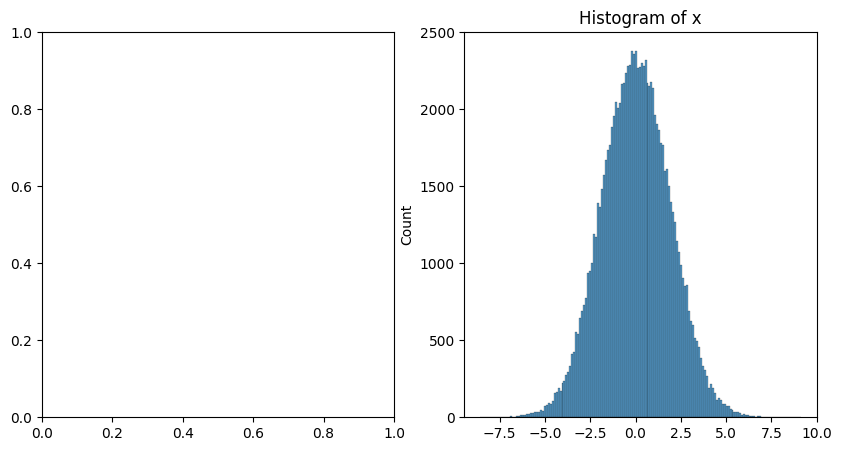

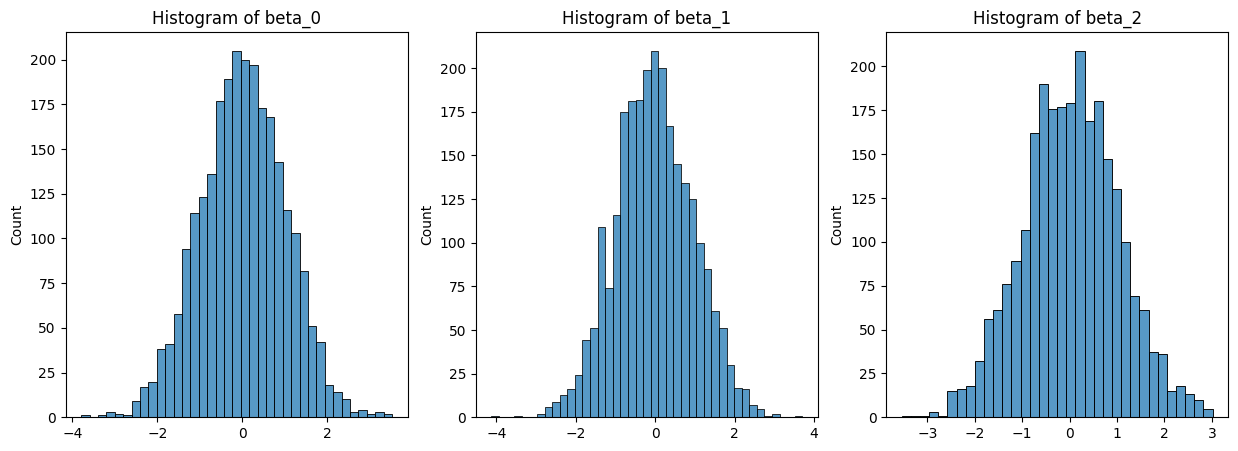

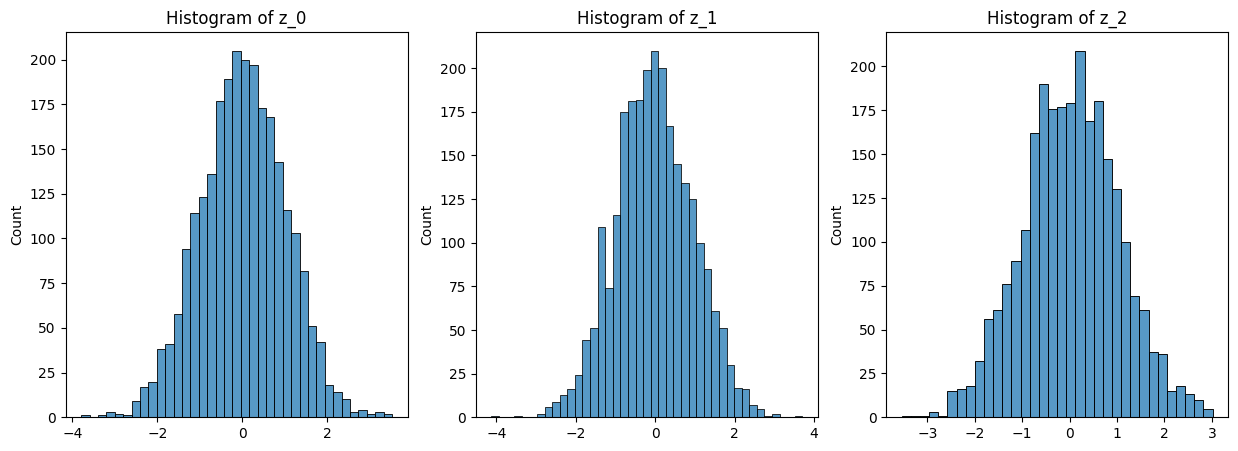

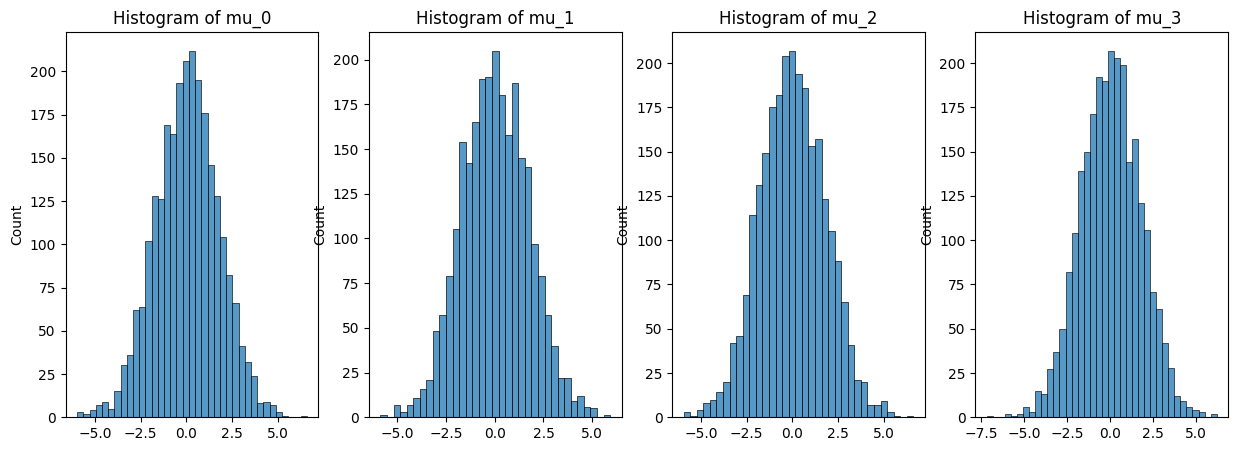

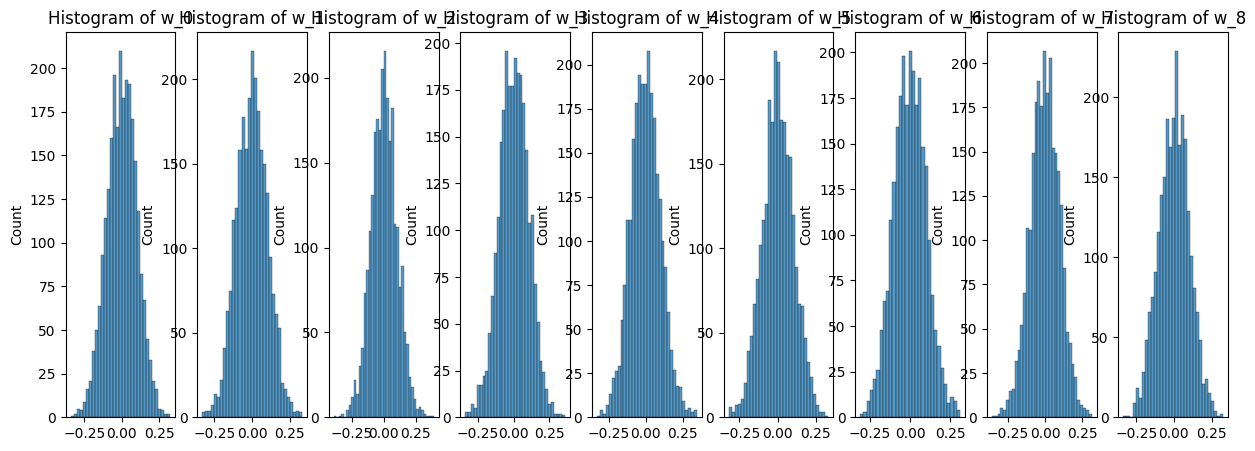

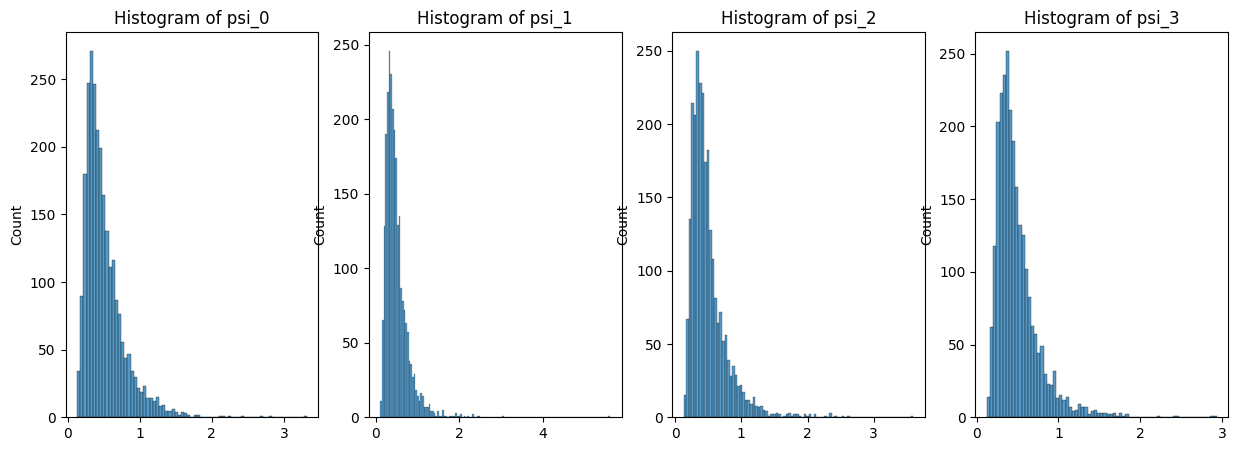

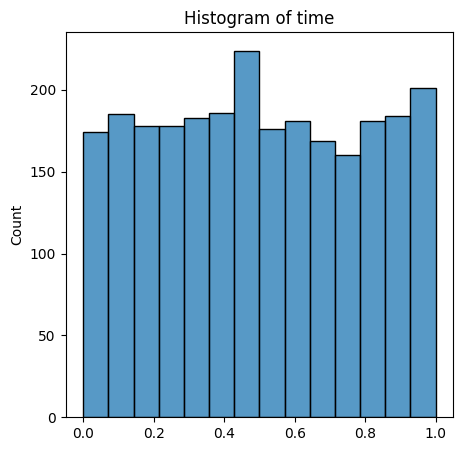

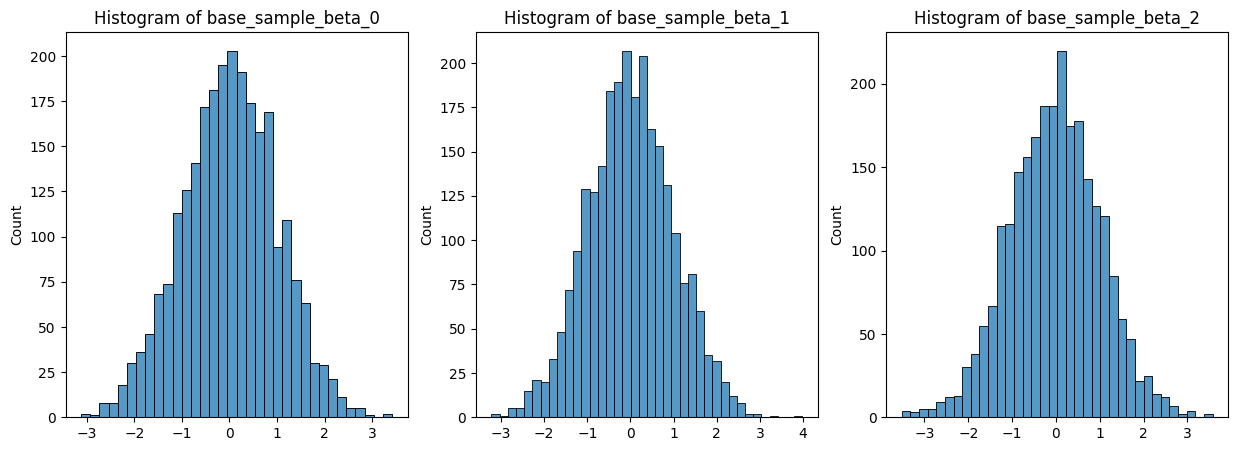

####################################################################################################
Epoch 99


100%|██████████| 10/10 [00:00<00:00, 33.84it/s]


{'X': {'mean': tensor(0.0075), 'variance': tensor(3.5292), 'min': tensor(-8.2659), 'max': tensor(8.1117), 'mean_mean': tensor([ 0.0582,  0.0006, -0.0096, -0.0192]), 'variance_mean': tensor([0.4960, 0.5065, 0.4979, 0.5079]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(-0.0097), 'variance': tensor(1.0135), 'min': tensor(-3.7898), 'max': tensor(3.7342), 'mean_mean': tensor(-0.0097), 'variance_mean': tensor(1.0301), 'min_mean': None, 'max_mean': None}}
Statistics for z:
Mean: tensor([-0.0070, -0.0247,  0.0028])
Variance: tensor([1.0371, 1.0015, 1.0020])
Min: tensor([-3.3976, -3.7898, -3.7609])
Max: tensor([3.7342, 3.1175, 3.3917])
Mean of means: -0.009651316329836845
Mean of variances: 1.030146837234497
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([ 0.0561,  0.0083, -0.0087, -0.0164])
Variance: tensor([2.9945, 2.9824, 2.9958, 2.9865])
Min: tensor([-6.1081, -6.2005, -5.3900, -6.6289])
Max: tensor([6.5164, 5.7917, 5.4066, 5.1590])
Mean of m

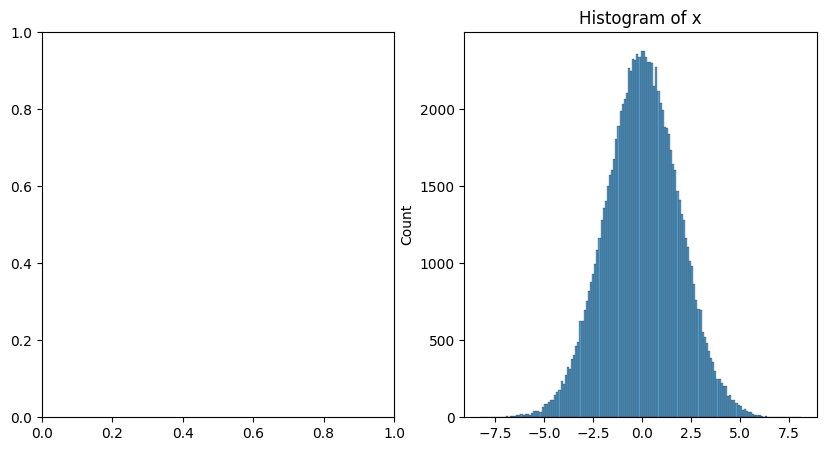

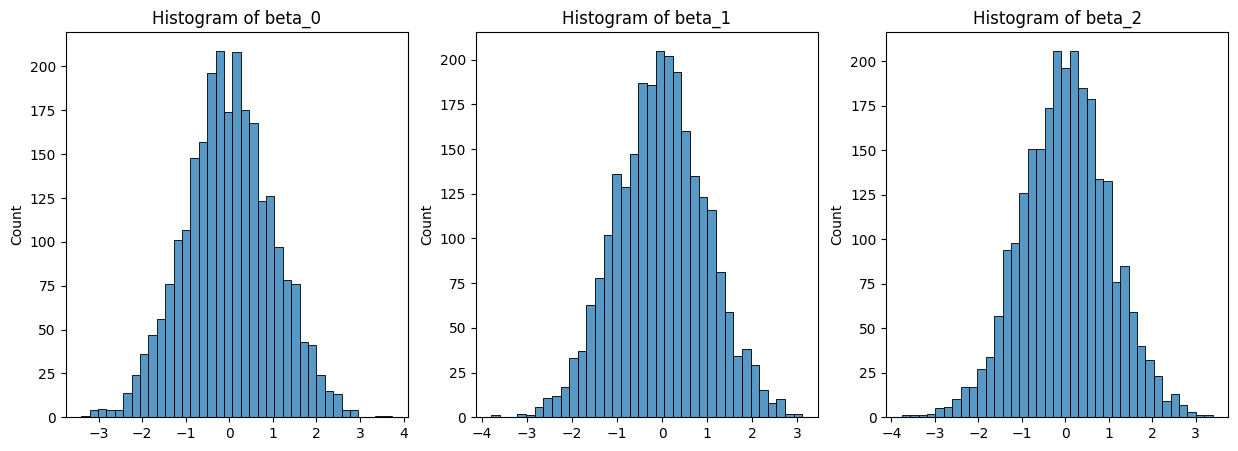

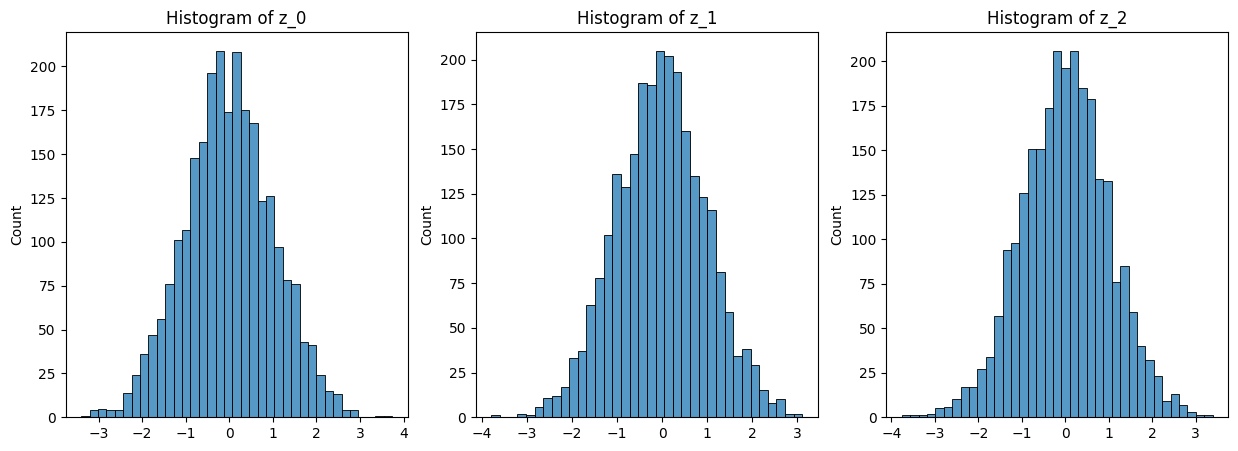

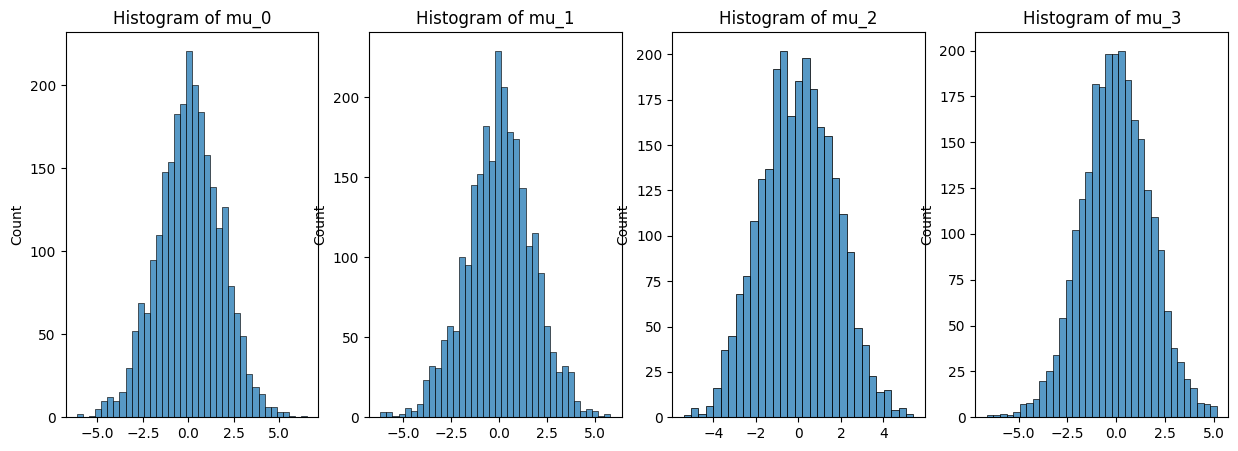

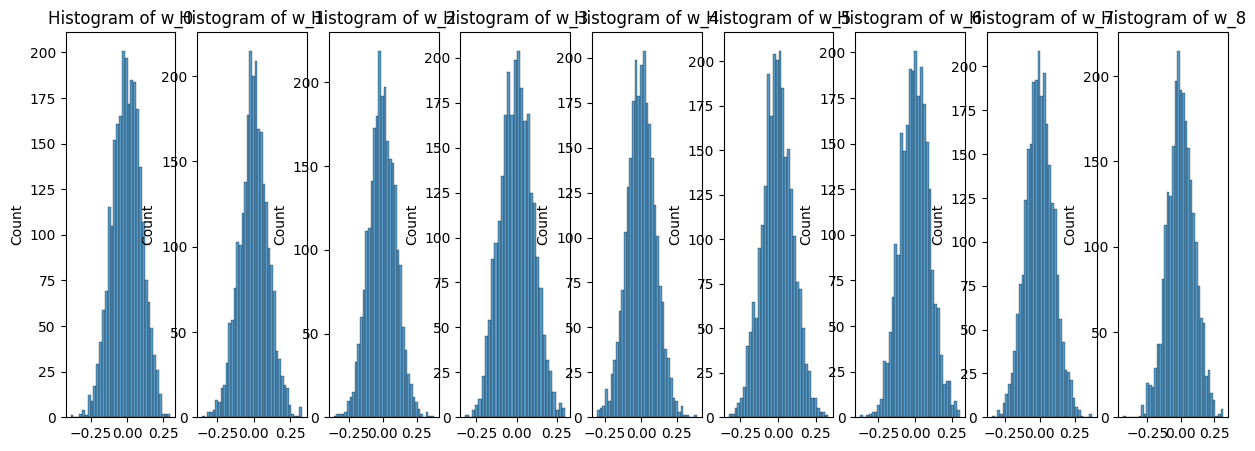

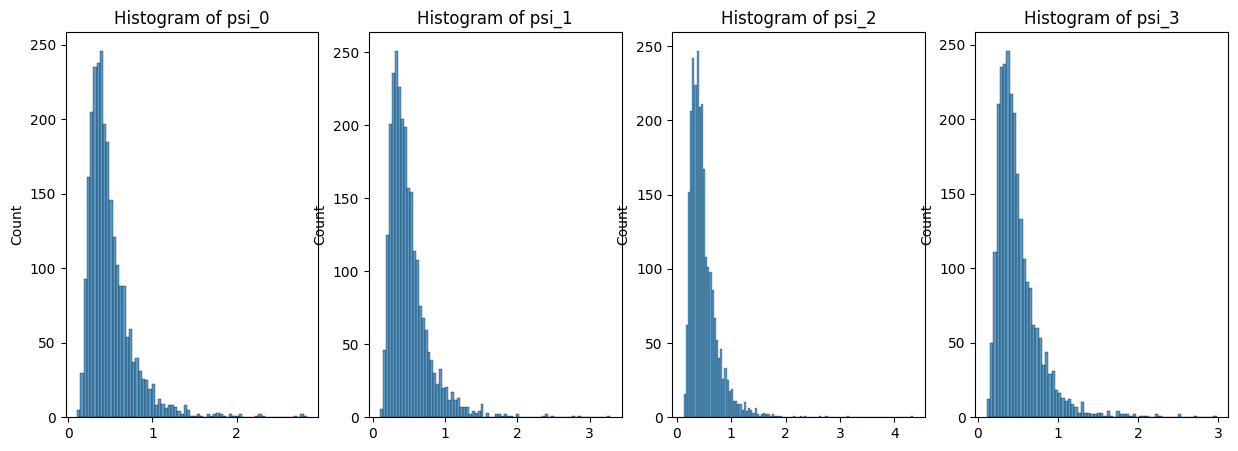

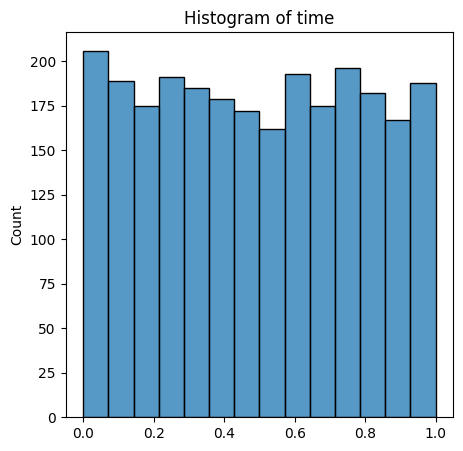

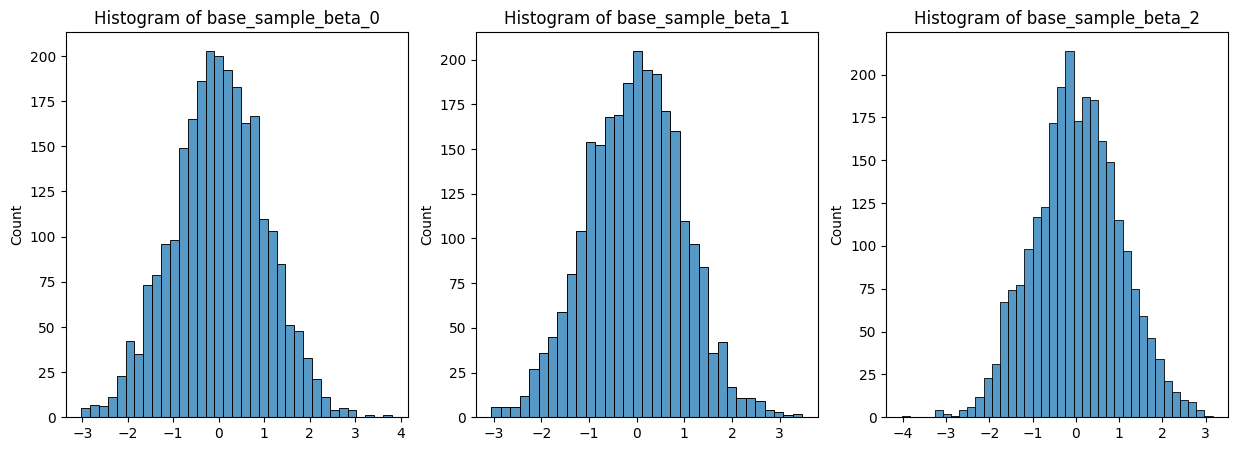

[{'X': {'mean': tensor(0.0276),
   'variance': tensor(3.5684),
   'min': tensor(-8.5601),
   'max': tensor(9.1200),
   'mean_mean': tensor([0.0300, 0.0191, 0.0256, 0.0357]),
   'variance_mean': tensor([0.5112, 0.5004, 0.5027, 0.4953]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(0.0065),
   'variance': tensor(0.9927),
   'min': tensor(-4.1257),
   'max': tensor(3.7068),
   'mean_mean': tensor(0.0065),
   'variance_mean': tensor(1.0153),
   'min_mean': None,
   'max_mean': None}},
 {'X': {'mean': tensor(0.0075),
   'variance': tensor(3.5292),
   'min': tensor(-8.2659),
   'max': tensor(8.1117),
   'mean_mean': tensor([ 0.0582,  0.0006, -0.0096, -0.0192]),
   'variance_mean': tensor([0.4960, 0.5065, 0.4979, 0.5079]),
   'min_mean': None,
   'max_mean': None},
  'beta': {'mean': tensor(-0.0097),
   'variance': tensor(1.0135),
   'min': tensor(-3.7898),
   'max': tensor(3.7342),
   'mean_mean': tensor(-0.0097),
   'variance_mean': tensor(1.0301),
   'min_mean': Non

In [115]:
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 10
)

In [116]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [117]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

dict_keys(['x', 'z', 'mu', 'w', 'psi', 'beta', 'time', 'base_sample_beta'])

In [118]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([1024, 10, 4]), torch.Size([1024, 3]))

In [119]:
2*K

6

In [120]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P,
    n_input_features_decoder = K,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = K,
    d_final_processing = 16,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [121]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [122]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [123]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [124]:
trainer.validate()

100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


{'loss_mean': 2.176123857498169,
 'loss_median': 2.1688034534454346,
 'loss_std': 0.04530429467558861}

In [125]:
r = trainer.train()

Curriculum parameters: {'n': 10, 'p': 5, 'batch_size': 1024, 'z_dim': 3, 'w_var': 0.1, 'mu_var': 3.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0} at iteration 0


 82%|████████▏ | 40/49 [00:09<00:02,  4.27it/s]


KeyboardInterrupt: 

In [126]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (K,),
    n_samples=1000,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 10,
    rtol = 10,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_fa_program_normal_weight_prior(**benchmark_params_ppgrogram)

pprogram1_x = return_only_x(pprogram1)



params for pprogram: {'n': 10, 'p': 5, 'z_dim': 3, 'w_var': 0.1, 'mu_var': 3.0, 'a1_psi_var': 5.0, 'b1_psi_var': 2.0}


In [127]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [128]:
x_test.shape

torch.Size([1024, 10, 4])

In [129]:
samples = full_model.sample_posterior(x_test[0])

0it [00:00, ?it/s]


In [130]:
samples["beta"].shape

torch.Size([1000, 3])

In [134]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1_x,
    n_samples=500,
    n_warmup=500
)

models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000, discrete_z=False)

In [138]:
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader = trainer.testset,
    comparison_models= [models[1]],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [139]:
evaluation.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [00:40<00:40, 40.20s/it]

....................


 78%|███████▊  | 78/100 [00:00<00:00, 392.40it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 100/100 [00:00<00:00, 371.67it/s]


An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

 30%|███       | 30/100 [00:00<00:00, 286.35it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

100%|██████████| 100/100 [00:00<00:00, 295.64it/s]

An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_samples=4.
An error occured in compare_samples_classifier_based: Cannot have number of splits n_splits=10 greater than the number of samples: n_sam

Comparison to ground truth:

Summarized results:


,Model,GT,Mean_joint_Wasserstein_distance with metric euclidean,Mean_joint_MMD,Mean_joint_cst_roc_auc,Mean_gt_parameter_Perplextiy,Mean_gt_parameter_MAP diff,Mean_gt_parameter_Mean diff,Std_joint_Wasserstein_distance with metric euclidean,Std_joint_MMD,Std_joint_cst_roc_auc,Std_gt_parameter_Perplextiy,Std_gt_parameter_MAP diff,Std_gt_parameter_Mean diff
0,<PFNExperiments.LinearRegression.Models.ModelT...,gt,5.297890e+11,7.129778,NaN,-6.285130e+13,2.209662e+11,2.209677e+11,0.000000,0.000000,NaN,7.729830e+13,4.570029e+08,4.563193e+08
1,Variational Inference with guide: AutoDiagonal...,gt,1.549570e+01,2.798336,NaN,-5.138022e+00,9.813867e-01,1.024262e+00,0.018986,0.001409,NaN,1.704101e+00,3.687791e-01,3.663585e-01


P-values:


,Model 1,Model 2,joint_Wasserstein_distance with metric euclidean_p-value,joint_MMD_p-value,joint_cst_roc_auc_p-value,gt_parameter_Perplextiy_p-value,gt_parameter_MAP diff_p-value,gt_parameter_Mean diff_p-value
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoDiagonal...,0.5,0.5,NaN,0.5,0.5,0.5



Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: AutoDiagonal...,5.297894e+11,7.742188,1.0,1.408997e+09,0.0,0.0


P-values:


""


{'summarized_results': {'comparison_to_gt':                                                Model  GT  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...  gt   
  1  Variational Inference with guide: AutoDiagonal...  gt   
  
     Mean_joint_Wasserstein_distance with metric euclidean  Mean_joint_MMD  \
  0                                       5.297890e+11            7.129778   
  1                                       1.549570e+01            2.798336   
  
     Mean_joint_cst_roc_auc  Mean_gt_parameter_Perplextiy  \
  0                     NaN                 -6.285130e+13   
  1                     NaN                 -5.138022e+00   
  
     Mean_gt_parameter_MAP diff  Mean_gt_parameter_Mean diff  \
  0                2.209662e+11                 2.209677e+11   
  1                9.813867e-01                 1.024262e+00   
  
     Std_joint_Wasserstein_distance with metric euclidean  Std_joint_MMD  \
  0                                           0.000000          0.000000   

In [ ]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [ ]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_multivariate_GMM import Preprocessor_GMM_multivariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_multivariate(
        N_datapoints = N,
        P_features = P,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [ ]:
comparison_models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

In [ ]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = comparison_models[1:3],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_z_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [ ]:
eval.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [00:37<00:37, 37.67s/it]

....................


Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [00:40<00:40, 40.20s/it]

....................


Sampling posterior: 100%|██████████| 2/2 [01:16<00:00, 38.45s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,7721.208740,7.742185,1.000,0.495458,6.743496e-07,0.000000
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,7721.141846,7.742185,1.000,0.466456,0.000000e+00,0.000000
2,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,1.105644,0.044285,0.695,0.077869,2.030804e-03,0.014849


P-values:


,Pair 1: Model A,Pair 1: Model B,Pair 2: Model A,Pair 2: Model B,Wasserstein_distance with metric euclidean_p-value,MMD_p-value,cst_roc_auc_p-value
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,0.698535,1.000000,1.000000
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,0.245278,0.245278,0.220671
2,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,0.245278,0.220671,0.220671


{'summarized_results': {'model_comparison_among_each_other':                                              Model 1  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...   
  1  <PFNExperiments.LinearRegression.Models.ModelT...   
  2  Variational Inference with guide: _bound_parti...   
  
                                               Model 2  \
  0  Variational Inference with guide: _bound_parti...   
  1  Variational Inference with guide: _bound_parti...   
  2  Variational Inference with guide: _bound_parti...   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                      7721.208740  7.742185   
  1                                      7721.141846  7.742185   
  2                                         1.105644  0.044285   
  
     Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean  \
  0             1.000                                        0.495458   
  1             1.000                                     